## Data cleaning and start survival analysis

In quetso notebook c'è questo

In [1]:
import pandas as pd
import glob
import os
import re

# Data Cleaning

In [24]:
# Step 1: Load population data
population_df = pd.read_csv(
    "scraping_correct/Datasets/complete_cleaned_copenhagen_population.csv",
    encoding="ISO-8859-1",
)

In [25]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   neighborhood_id    474 non-null    int64 
 1   neighborhood_name  474 non-null    object
 2   postal_code        474 non-null    int64 
 3   postal_area        474 non-null    object
 4   postal_code_m2     474 non-null    object
 5   Total              474 non-null    int64 
 6   Men                474 non-null    int64 
 7   Women              474 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 29.8+ KB


In [26]:
# Cerca tutti i file CSV con nomi coerenti
file_paths = glob.glob("scraping_correct/Datasets/Temp/scraped_companies_*.csv")

all_dfs = []

for path in file_paths:
    filename = os.path.basename(path)

    # Estrai il codice a 6 cifre
    try:
        code = filename.split("_")[2]
    except IndexError:
        code = "000000"  # fallback se il nome non è nel formato atteso

    # Determina se è attivo
    is_active = filename.lower().endswith("active.csv")

    # Carica il file
    df = pd.read_csv(path)

    # Aggiungi le colonne
    df["code"] = code
    df["active"] = is_active

    all_dfs.append(df)

# Unisci tutto in un unico DataFrame
merged_df = pd.concat(all_dfs, ignore_index=True)

# Salva il risultato
merged_df.to_csv("merged_companies.csv", index=False)

print("✅ Unione completata. File salvato come merged_companies.csv")

✅ Unione completata. File salvato come merged_companies.csv


In [27]:
# Funzione per estrarre il codice postale a 4 cifre dopo la prima virgola
def extract_postal_code(address):
    try:
        # Cerca la sequenza ", XXXX" dove X sono cifre
        match = re.search(r",\s*(\d{4})", address)
        return match.group(1) if match else None
    except:
        return None


# Applica la funzione alla colonna Address
merged_df["postal_code"] = merged_df["Address"].apply(extract_postal_code)

In [28]:
merged_df = merged_df.drop(columns=["Status"])
merged_df = merged_df.drop(columns=["Company Type"])
merged_df.head()

,Name,Address,P-nummer,Startdate,Enddate,code,active,postal_code
0,Frankies Pizza Nørrebro,"Sortedam Dossering 3B, 2200 København N",1019849178,30.10.2014,01.05.2025,561110,True,2200
1,Søartilleriet,"Jorisvej 5, 2. 108, 2300 København S",1029736347,12.10.2023,NaN,561110,True,2300
2,Indian Flames,"Griffenfeldsgade 13, 2200 København N",1029776292,01.11.2023,NaN,561110,True,2200
3,Veksø cafe & Restaurant ApS,"Veksø Bygade 13, 3670 Veksø Sjælland",1029823061,08.11.2023,NaN,561110,True,3670
4,Khun Juk ApS,"Nyhavn 63D, 1051 København K",1029838999,15.11.2023,NaN,561110,True,1051


In [29]:
population_df = population_df.rename(columns={"neighborhood_id": "neighborhood_code"})
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   neighborhood_code  474 non-null    int64 
 1   neighborhood_name  474 non-null    object
 2   postal_code        474 non-null    int64 
 3   postal_area        474 non-null    object
 4   postal_code_m2     474 non-null    object
 5   Total              474 non-null    int64 
 6   Men                474 non-null    int64 
 7   Women              474 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 29.8+ KB


In [30]:
population_df = population_df.replace("-", 0)

In [31]:
# Converte postal_code in stringa per evitare problemi nei join
population_df["postal_code"] = population_df["postal_code"].astype(str)
population_df["postal_code_m2"] = population_df["postal_code_m2"].astype(int)
population_df[""] = population_df["postal_code_m2"].astype(int)
population_df["postal_code_m2"] = population_df["postal_code_m2"].astype(int)
merged_df["postal_code"] = merged_df["postal_code"].astype(str)


# 1. Densità di popolazione (abitanti per km²)
population_df["population_density_km2"] = population_df["Total"] / (
    population_df["postal_code_m2"] / 1_000_000
)

# 2. Conteggio ristoranti per codice postale
restaurant_counts = (
    merged_df.groupby("postal_code").size().reset_index(name="restaurant_count")
)

# 3. Join dei ristoranti con il DataFrame della popolazione
population_df = population_df.merge(restaurant_counts, on="postal_code", how="left")
population_df["restaurant_count"] = (
    population_df["restaurant_count"].fillna(0).astype(int)
)

# Salva il nuovo dataset
population_df.to_csv("population_df.csv", index=False)

In [32]:
population_df.head()

,neighborhood_code,neighborhood_name,postal_code,postal_area,postal_code_m2,Total,Men,Women,,population_density_km2,restaurant_count
0,101,København,1050,København K,39053,20,10,10,39053,512.124549,16
1,101,København,1051,København K,55643,399,191,208,55643,7170.713297,28
2,101,København,1052,København K,6563,421,204,217,6563,64147.493524,2
3,101,København,1053,København K,2434,404,181,223,2434,165981.922761,2
4,101,København,1054,København K,4953,392,201,191,4953,79143.953160,1


# Sruvival Analysis

We need to prepare the data for the first part of the survival analysis.

1. We start with the Kaplan-Meier model to explore survival curves and detect patterns.
2. After that, we'll integrate the Cox PH to quantify what matters and predict survival risk using your features.

## Kaplan-Meyer

In [3]:
# Dataset preparation
#  name | start_date | end_date | is_closed | duration_days | group
restaurants_df = pd.read_csv("restaurants_df.csv")
survival_df = restaurants_df[["Name", "Startdate", "Enddate", "active", "postal_code"]]

# Convert Startdate and Enddate to datetime
survival_df["Startdate"] = pd.to_datetime(survival_df["Startdate"], errors="coerce")
survival_df["Enddate"] = pd.to_datetime(survival_df["Enddate"], errors="coerce")


# Today's date (for open restaurants)
today = pd.to_datetime("today")

# Duration in days
survival_df["end_calc"] = survival_df["Enddate"].fillna(today)
survival_df["duration_days"] = (
    survival_df["end_calc"] - survival_df["Startdate"]
).dt.days

# Event observed: 1 if restaurant closed, 0 if still active
survival_df["is_closed"] = survival_df["active"].apply(lambda x: 0 if x else 1)

survival_df.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_14792\1719573381.py:7: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  survival_df["Startdate"] = pd.to_datetime(survival_df["Startdate"], errors="coerce")
C:\Users\Dell\AppData\Local\Temp\ipykernel_14792\1719573381.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df["Startdate"] = pd.to_datetime(survival_df["Startdate"], errors="coerce")
C:\Users\Dell\AppData\Local\Temp\ipykernel_14792\1719573381.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Name,Startdate,Enddate,active,postal_code,end_calc,duration_days,is_closed
0,Frankies Pizza Nørrebro,2014-10-30,2025-01-05,True,2200,2025-01-05 00:00:00.000000,3720.0,0
1,Søartilleriet,2023-10-12,NaT,True,2300,2025-04-25 09:44:19.393518,561.0,0
2,Indian Flames,2023-11-01,NaT,True,2200,2025-04-25 09:44:19.393518,541.0,0
3,Veksø cafe & Restaurant ApS,2023-11-08,NaT,True,3670,2025-04-25 09:44:19.393518,534.0,0
4,Khun Juk ApS,2023-11-15,NaT,True,1051,2025-04-25 09:44:19.393518,527.0,0


In [ ]:
# !pip install lifelines

In [5]:
pd.DataFrame.count(survival_df[survival_df["duration_days"].isna()])

Name             37
Startdate         0
Enddate           0
active           37
postal_code      37
end_calc         37
duration_days     0
is_closed        37
dtype: int64

In [6]:
survival_df = survival_df.dropna(subset=["Startdate", "duration_days"])

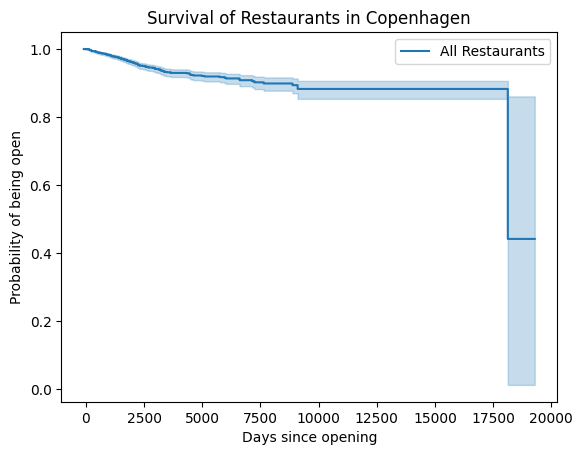

In [7]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Load your data
# df = pd.read_csv("your_restaurant_data.csv")  # or use a DataFrame directly

# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Plot for all restaurants
kmf.fit(
    durations=survival_df["duration_days"],
    event_observed=survival_df["is_closed"],
    label="All Restaurants",
)
kmf.plot_survival_function()
plt.title("Survival of Restaurants in Copenhagen")
plt.xlabel("Days since opening")
plt.ylabel("Probability of being open")
plt.show()

recommendation_score = α * pop_density - β * competition + γ * review_score + δ * survival_score


## Cox Model

It models the hazard of closing as a function of other features:

"How does price, rating, foot traffic, population, etc. influence the closure risk of a restaurant?"

### Fix datasets

In [8]:
# Load the dataset
maps_df = pd.read_csv(
    "scraping_correct/Datasets/maps_data_scraped.csv",
    encoding="ISO-8859-1",
)
unique_price_levels = maps_df["Price Level"].unique()
print(unique_price_levels)

[nan '100-200 kr a persona' '400-500 kr a persona' '200-300 kr a persona'
 'PiÃ¹ di 1000 kr a persona' '1-100 kr a persona' '300-400 kr a persona'
 '600-700 kr a persona' '100-300 kr a persona' '200-400 kr a persona'
 '1-200 kr a persona' '300-500 kr a persona' '400-600 kr a persona'
 '500-600 kr a persona' '30-40 â\x82¬ a persona' '2000-4000 kr a persona'
 '1-10 â\x82¬ a persona']


In [9]:
price_mapping = {
    "1-100 kr a persona": 1,
    "1-200 kr a persona": 1,
    "100-200 kr a persona": 1,
    "100-300 kr a persona": 2,
    "200-300 kr a persona": 2,
    "200-400 kr a persona": 2,
    "300-400 kr a persona": 3,
    "300-500 kr a persona": 3,
    "400-500 kr a persona": 3,
    "400-600 kr a persona": 3,
    "500-600 kr a persona": 3,
    "600-700 kr a persona": 4,
    "Più di 1000 kr a persona": 5,
    "2000-4000 kr a persona": 5,
    "1-10 â\x82¬ a persona": 1,  # ≈ 7–75 DKK
    "30-40 â\x82¬ a persona": 2,  # ≈ 224–298 DKK
}

maps_df["Price Level"] = maps_df["Price Level"].map(price_mapping)
unique_price_levels = maps_df["Price Level"].unique()
print(unique_price_levels)

[nan  1.  3.  2.  4.  5.]


In [15]:
maps_df["Price Level"].isna().sum()
# maps_df["Price Level"].notna().sum()

3643

In [16]:
maps_df.isna().sum()

Input Name          0
Input Address       0
Title            2025
Rating           2155
Reviews          2180
Price Level      3643
Tags             2949
dtype: int64